In [12]:
import os
import kagglehub
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Download the dataset
path = kagglehub.dataset_download("jagdishchakole1/mango-data")
print("Path to dataset files:", path)

# Define data directories
train_dir = os.path.join(path, "Mango_leaf_disease1/train")
val_dir = os.path.join(path, "Mango_leaf_disease1/val")
test_dir = os.path.join(path, "Mango_leaf_disease1/test")

# Print dataset statistics
print("Training data path:", train_dir)
print("Validation data path:", val_dir)
print("Test data path:", test_dir)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


Path to dataset files: /kaggle/input/mango-data
Training data path: /kaggle/input/mango-data/Mango_leaf_disease1/train
Validation data path: /kaggle/input/mango-data/Mango_leaf_disease1/val
Test data path: /kaggle/input/mango-data/Mango_leaf_disease1/test


In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Print class details
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_generator.class_indices)


Found 2800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Number of classes: 8
Class mapping: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


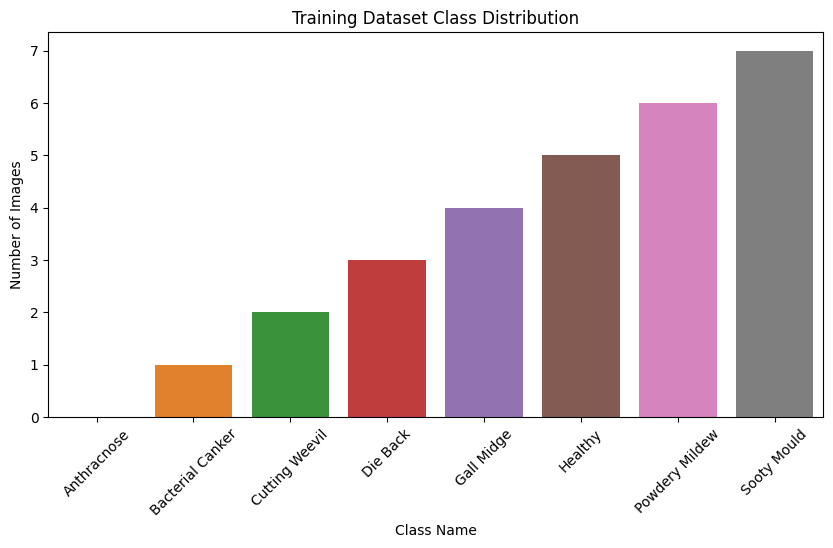

In [14]:
class_counts = train_generator.class_indices
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.title("Training Dataset Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [16]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom Layers
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    'vgg19_best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 57s 255ms/step - accuracy: 0.3033 - loss: 2.2045 - val_accuracy: 0.8138 - val_loss: 0.6486
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 256ms/step - accuracy: 0.6672 - loss: 0.9104 - val_accuracy: 0.8725 - val_loss: 0.3928
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 256ms/step - accuracy: 0.7480 - loss: 0.6898 - val_accuracy: 0.9112 - val_loss: 0.2948
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 47s 258ms/step - accuracy: 0.7929 - loss: 0.5863 - val_accuracy: 0.9212 - val_loss: 0.2422
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 253ms/step - accuracy: 0.8207 - loss: 0.4813 - val_accuracy: 0.9237 - val_loss: 0.2100
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 252ms/step - accuracy: 0.8564 - loss: 0.4268 - val_accuracy: 

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9523 - loss: 0.1333
Test Loss: 0.1428
Test Accuracy: 0.9475


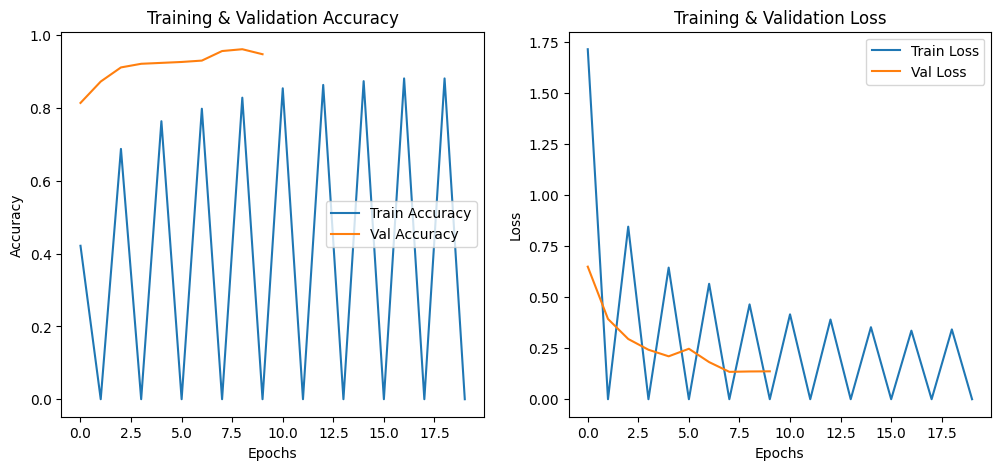

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


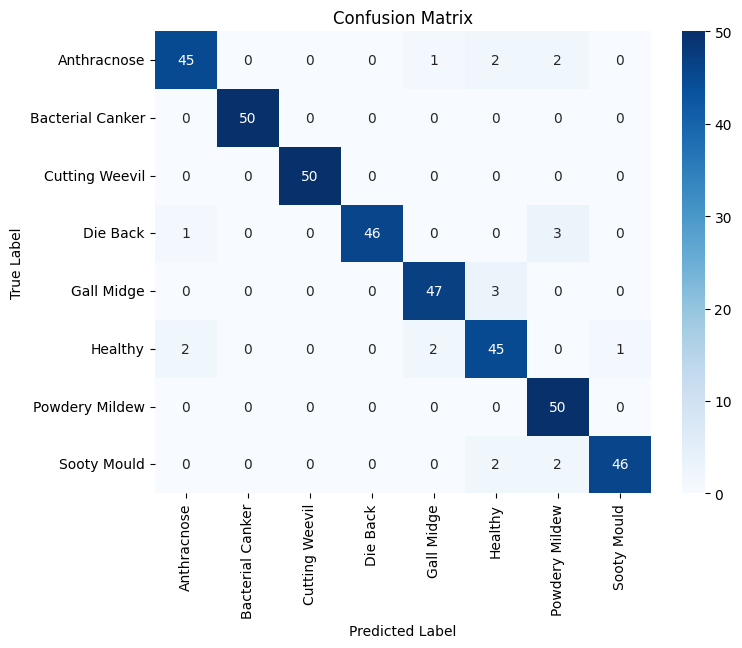


Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       0.94      0.90      0.92        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      0.92      0.96        50
      Gall Midge       0.94      0.94      0.94        50
         Healthy       0.87      0.90      0.88        50
  Powdery Mildew       0.88      1.00      0.93        50
     Sooty Mould       0.98      0.92      0.95        50

        accuracy                           0.95       400
       macro avg       0.95      0.95      0.95       400
    weighted avg       0.95      0.95      0.95       400



In [17]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))
